In [1]:
using Cubature

In [2]:
function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function Z(n, m, ρ, θ)
    if m < 0
        R(n, abs(m), ρ) * sin(abs(m) * θ)
    else
        R(n, m, ρ) * cos(m * θ)
    end
end

Z (generic function with 1 method)

In [3]:
σ1 = .1
σ2 = 1
displacement = 0
function integrand(n, m)
    function rtn(coor)
        ρ = coor[1]
        θ = coor[2]
        x = ρ * cos(θ) + displacement
        y = ρ * sin(θ)
        Z(n, m, ρ, θ) * exp(-x^2/σ1^2 - y^2/σ2^2) * ρ
    end
    rtn
end

integrand (generic function with 1 method)

In [4]:
function neumann(m)
    if m == 0
        2
    else 
        1
    end
end
function cond_eval(n, m)
    if -n ≤ m ≤ n
        (2*n+2)/(π*neumann(m)) * hcubature(integrand(n, m), [0., 0.], [1., 2*π], maxevals=10000)[1]
    else
        0
    end
end

cond_eval (generic function with 1 method)

In [5]:
# maxn=100
# coeffs1 = [sum([c[1]^2 for c in [cond_eval(n, m) for n in range(0, maxn, step=1)]]) for m in range(0, maxn, step=1)];
# coeffs2 = [sum([c[1]^2 for c in [cond_eval(n, m) for n in range(0, maxn, step=1)]]) for m in range(-maxn, 0, step=1)];

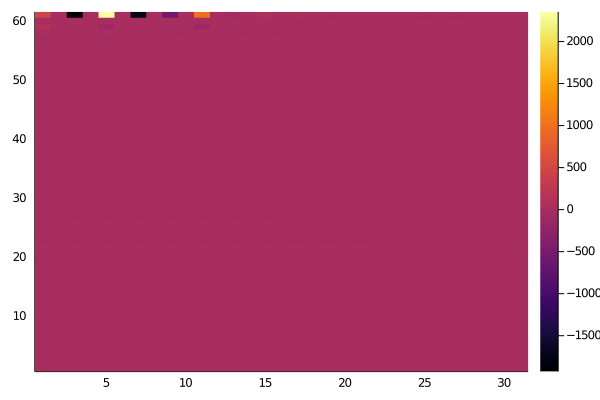

In [7]:
using Plots
gr()
maxn = 30

heatmap(hcat([[c[1] for c in [cond_eval(n, m) for n in range(0, 2*maxn, step=1)]] for m in range(0, maxn, step=1)]...))